## 1. Import Libraries and Load Data

In [513]:
# Libraries
import warnings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.neighbors import NearestNeighbors

# Set-up environment
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="whitegrid", context="paper")
os.chdir('/Users/nataschajademinnitt/Documents/5. Data Analysis/segmenting_customers/')
print("Current directory:", os.getcwd())
warnings.filterwarnings("ignore")

Current directory: /Users/nataschajademinnitt/Documents/5. Data Analysis/segmenting_customers


In [793]:
# Load the data
df = pd.read_csv("./data/processed/processed_database.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72613 entries, 0 to 72612
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   recency                   72613 non-null  int64  
 1   recent_flag               72613 non-null  int64  
 2   f_orders                  72613 non-null  int64  
 3   f_products                72613 non-null  int64  
 4   f_basket_size             72613 non-null  float64
 5   f_bulk_flag               72613 non-null  int64  
 6   f_returning               72613 non-null  int64  
 7   m_price_log               72613 non-null  float64
 8   m_pct_freight             72613 non-null  float64
 9   m_purchasing_power        72613 non-null  int64  
 10  m_value_installments      72613 non-null  float64
 11  m_total_installments      72613 non-null  float64
 12  m_value_installments_log  72613 non-null  float64
 13  m_credit                  72613 non-null  float64
 14  s_revi

## 2. Functions

In [542]:
def evaluate_feature_sets(
    df,
    dict_features,
    scaler,
    k_min: int = 2,
    k_max: int = 10,
    random_state: int = 42
) -> pd.DataFrame:
    """
    Uses a dictionary of features to find the best k elbow.
    Computes silhouette, calinski_harabasz and davies_bouldin at that k.
    """
    results = []

    for name, cols in dict_features.items():
        X = df[cols].values
        
        # use the passed‑in scaler
        X_scaled = scaler.fit_transform(X)
        
        # find the elbow
        model = KMeans(random_state=random_state)
        viz = KElbowVisualizer(
            model,
            k=(k_min, k_max),
            metric='distortion',
            show=False,
            timings=False
        )
        viz.fit(X_scaled)
        best_k = viz.elbow_value_
        
        # compute internal scores
        labels = KMeans(n_clusters=best_k, random_state=random_state).fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, labels)
        ch  = calinski_harabasz_score(X_scaled, labels)
        db  = davies_bouldin_score(X_scaled, labels)
        
        results.append({
            'feature_set': name,
            'scaler': scaler.__class__.__name__,
            'best_k_elbow': best_k,
            'silhouette_score': sil,
            'calinski_harabasz_score': ch,
            'davies_bouldin_score': db
        })

    return pd.DataFrame(results)

In [220]:
def evaluate_clusters(
    data,
    feature_cols=None,
    metric="distortion",
    k_min=2,
    k_max=10,
    random_state=42
):
    """
    Evaluate clustering (elbow, silhouette, intercluster distance) for a set of features.
    
    """

    # 2) Subset & scale once
    X = data[feature_cols].values
    scaler = MinMaxScaler().fit(X)
    X_scaled = scaler.transform(X)

    # 3) Make your 3‑panel canvas
    fig, axes = plt.subplots(3, 1, figsize=(6, 10))

    # Elbow
    kelbow = KElbowVisualizer(
        KMeans(random_state=random_state),
        k=(k_min, k_max),
        metric=metric,
        ax=axes[0]
    )
    kelbow.fit(X_scaled)
    best_k = kelbow.elbow_value_
    kelbow.finalize()

    # Silhouette
    silvis = SilhouetteVisualizer(
        KMeans(n_clusters=best_k, random_state=random_state),
        ax=axes[1]
    )
    silvis.fit(X_scaled)
    silvis.finalize()

    # Inter‑cluster distances
    icd = InterclusterDistance(
        KMeans(n_clusters=best_k, random_state=random_state),
        ax=axes[2]
    )
    icd.fit(X_scaled)
    icd.finalize()

    plt.tight_layout()
    plt.show()

    return best_k, fig

In [74]:
def plot_cluster_radar(df, title="Cluster Radar Plot"):
    """
    Create a radar (spider) plot for cluster profiles.
    """
    # Number of variables
    features = df.columns.tolist()
    num_vars = len(features)

    # Compute angles for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # complete the loop

    # Setup polar plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    fig.suptitle(title, fontsize=14, fontweight='bold')

    # Plot each cluster
    for idx, row in df.iterrows():
        values = row.values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=str(idx))
        ax.fill(angles, values, alpha=0.25)

    # Add feature labels on the axes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)

    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    plt.tight_layout()
    plt.show()

## 3. Comparing Models

### 3.1. K-Means Clustering

#### Baseline Performance

Comaring the baseline performance of k-means clustering for feature combinations using different sclaers: MinMax, Standard, Robust.

In [549]:
dict_features = {
    # 1) RFM baseline
    'rfm': ['recency', 'f_returning', 'm_price_log'],

    # 2) RFM + s_review_score
    'rfm_score': ['recency', 'f_returning', 'm_price_log', 's_review_score'],

    # 3) RFM + s_delivery_diff_binary
    'rfm_deliv': ['recency', 'f_returning', 'm_price_log', 's_delivery_diff_binary'],
    
    # 4) RFM + m_pct_freight
    'rfm_freight': ['recency', 'f_returning', 'm_price_log', 'm_pct_freight'],

    # 5) RFM + m_credit
    'rfm_credit': ['recency', 'f_returning', 'm_price_log', 'f_basket_size']
    
}

In [ ]:
# Compare clustering performance
res_mm = evaluate_feature_sets(df, dict_features, scaler=MinMaxScaler())
res_std = evaluate_feature_sets(df, dict_features, scaler=StandardScaler())
res_rob = evaluate_feature_sets(df, dict_features, scaler=RobustScaler())

In [562]:
# Display results df
df_baseline = pd.concat([res_mm, res_std, res_rob], ignore_index=True)
df_baseline.sort_values('silhouette_score', ascending=False)

,feature_set,scaler,best_k_elbow,silhouette_score,calinski_harabasz_score,davies_bouldin_score
4,rfm_credit,MinMaxScaler,4,0.60,121836.59,0.54
2,rfm_deliv,MinMaxScaler,4,0.55,115968.38,0.55
0,rfm,MinMaxScaler,3,0.54,152371.46,0.59
9,rfm_credit,StandardScaler,5,0.50,41994.33,0.68
14,rfm_credit,RobustScaler,5,0.48,51721.76,0.70
1,rfm_score,MinMaxScaler,4,0.44,66215.42,0.76
3,rfm_freight,MinMaxScaler,4,0.43,68194.47,0.77
7,rfm_deliv,StandardScaler,4,0.40,43833.95,0.89
5,rfm,StandardScaler,4,0.37,50807.67,0.88
8,rfm_freight,StandardScaler,4,0.35,41210.71,0.95


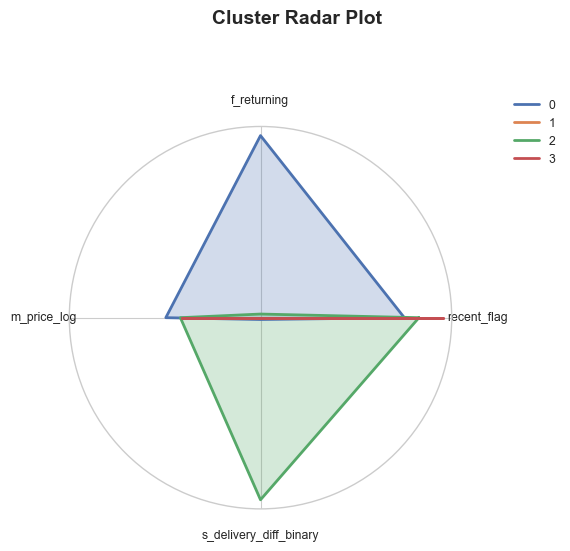

,recent_flag,f_returning,m_price_log,s_delivery_diff_binary
cluster,,,,
0,0.79,1.00,0.52,0.01
1,0.32,0.00,0.43,0.00
2,0.87,0.02,0.44,1.00
3,1.00,0.00,0.43,0.00


In [810]:
# Radar plot
features = ['recent_flag', 'f_returning', 'm_price_log', 's_delivery_diff_binary']

X = df[features].values
X_scaled = MinMaxScaler().fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42).fit(X_scaled)
labels = kmeans.labels_

dfb = pd.DataFrame(X_scaled, columns=features)
dfb['cluster'] = labels

profile = dfb.groupby('cluster').mean().round(2)

plot_cluster_radar(profile)
profile

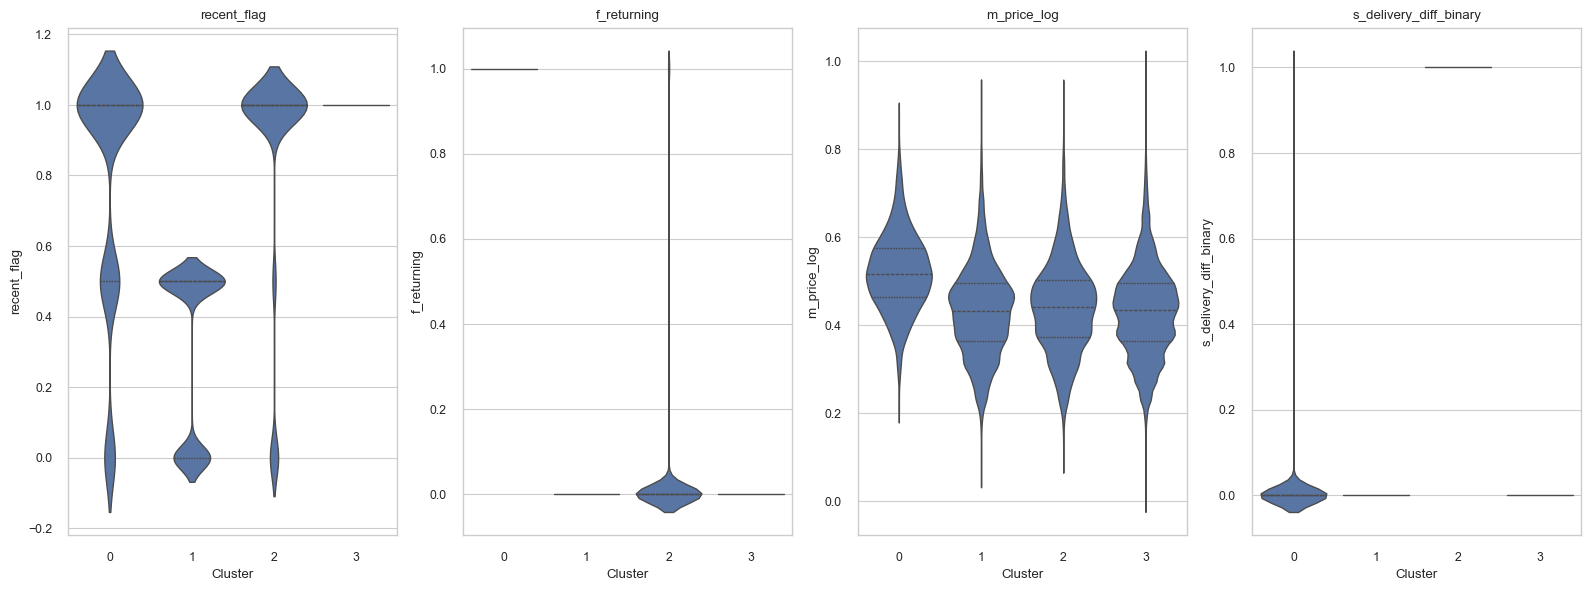

In [814]:
# Violin plot
fig, axes = plt.subplots(1, len(features), figsize=(len(features)*4, 6), sharey=False)

for ax, feature in zip(axes, features):
    sns.violinplot(
        x='cluster', y=feature,
        data=dfb, ax=ax,
        inner='quartile', scale='width'
    )
    ax.set_title(feature)
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)

fig.tight_layout()
plt.show()

In [705]:
dict_features = {
    'rfm_1': ['recency', 'f_returning', 'm_price_log'],

    'rfm_2': ['recency', 'f_returning', 'm_value_installments_log'],

    'rfm_3': ['recency', 'f_returning', 'm_price_log', 's_deliv_clipped'],
    
    'rfm_4': ['recency', 'f_returning', 'm_value_installments_log', 's_deliv_clipped'],

    'rfm_5': ['recency', 'f_returning', 'm_price_log', 'f_bulk_flag'],

    'rfm_6': ['recency', 'f_returning', 'm_value_installments_log', 'f_bulk_flag']
    
}

In [ ]:
# Compare clustering performance
res_mm = evaluate_feature_sets(df, dict_features, scaler=MinMaxScaler())
res_std = evaluate_feature_sets(df, dict_features, scaler=StandardScaler())
res_rob = evaluate_feature_sets(df, dict_features, scaler=RobustScaler())

In [716]:
# Display results df
df_baseline_2 = pd.concat([res_mm, res_std, res_rob], ignore_index=True)
df_baseline_2.sort_values('silhouette_score', ascending=False)

,feature_set,scaler,best_k_elbow,silhouette_score,calinski_harabasz_score,davies_bouldin_score
5,rfm_6,MinMaxScaler,3,0.54,153246.95,0.58
1,rfm_2,MinMaxScaler,3,0.54,153246.95,0.58
0,rfm_1,MinMaxScaler,3,0.54,152212.00,0.59
4,rfm_5,MinMaxScaler,3,0.54,152212.02,0.59
3,rfm_4,MinMaxScaler,3,0.45,94698.73,0.76
2,rfm_3,MinMaxScaler,3,0.45,94333.13,0.77
6,rfm_1,StandardScaler,4,0.37,50256.54,0.88
10,rfm_5,StandardScaler,4,0.37,50256.54,0.88
11,rfm_6,StandardScaler,4,0.36,48260.95,0.89
7,rfm_2,StandardScaler,4,0.36,48238.49,0.89


**Evaluate the performance of each features for the best set**

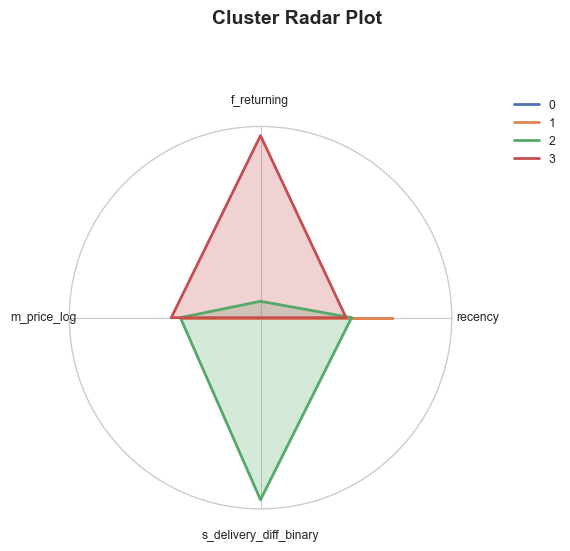

,recency,f_returning,m_price_log,s_delivery_diff_binary
cluster,,,,
0,0.24,0.00,0.43,0.00
1,0.72,0.00,0.43,0.00
2,0.50,0.09,0.44,1.00
3,0.47,1.00,0.49,0.00


In [598]:
# Radar plot
features = ['recency', 'f_returning', 'm_price_log', 's_delivery_diff_binary']

X = df[features].values
X_scaled = MinMaxScaler().fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42).fit(X_scaled)
labels = kmeans.labels_

dfb = pd.DataFrame(X_scaled, columns=features)
dfb['cluster'] = labels

profile = dfb.groupby('cluster').mean().round(2)

plot_cluster_radar(profile)
profile

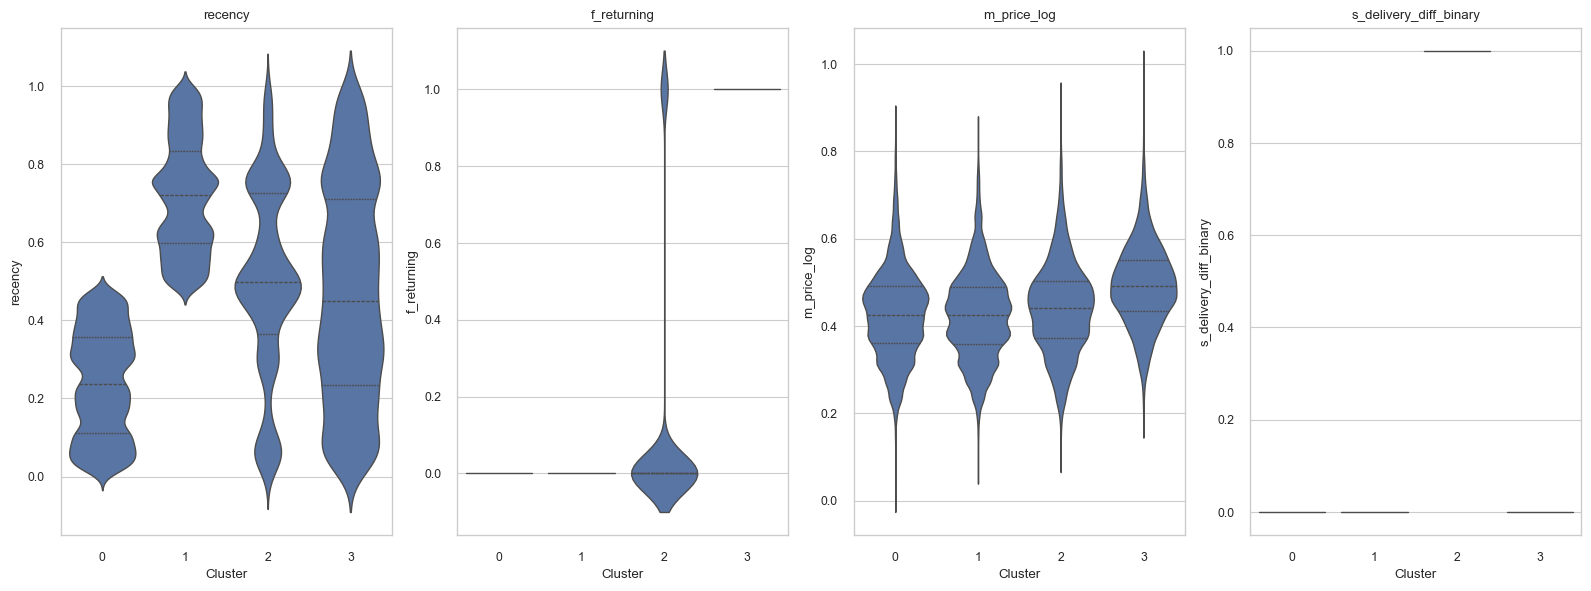

In [568]:
# Violin plot
fig, axes = plt.subplots(1, len(features), figsize=(len(features)*4, 6), sharey=False)

for ax, feature in zip(axes, features):
    sns.violinplot(
        x='cluster', y=feature,
        data=dfb, ax=ax,
        inner='quartile', scale='width'
    )
    ax.set_title(feature)
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)

fig.tight_layout()
plt.show()

#### Recency and Monetary adjustments

Comparing recency as a continious and categorical feature with monetary as continious and ratio of installments.

In [627]:
dict_features = {
    'rfm_cont_instal': ['recency', 'f_returning', 'm_value_installments', 'f_basket_size', 's_delivery_diff_binary'],

    'rfm_cont_log': ['recency', 'f_returning', 'm_price_log', 'f_basket_size', 's_delivery_diff_binary'],
    
    'rfm_flag_instal': ['recent_flag', 'f_returning', 'm_value_installments', 'f_basket_size', 's_delivery_diff_binary'],
    
    'rfm_flag_log': ['recent_flag', 'f_returning', 'm_price_log', 'f_basket_size', 's_delivery_diff_binary'],
}

,feature_set,scaler,best_k_elbow,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,rfm_cont_instal,MinMaxScaler,4,0.61,121331.64,0.49
1,rfm_cont_log,MinMaxScaler,4,0.54,100293.46,0.59
2,rfm_flag_instal,MinMaxScaler,4,0.84,125419.79,0.50
3,rfm_flag_log,MinMaxScaler,4,0.72,104900.54,0.55


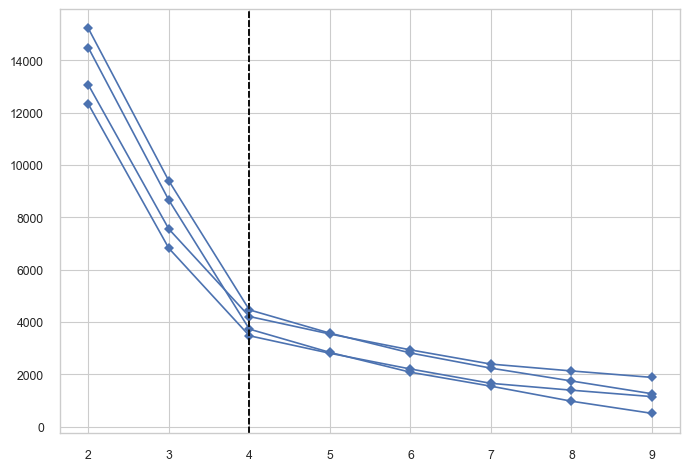

In [629]:
# Compare clustering performance
results_df = evaluate_feature_sets(df, dict_features, scaler=MinMaxScaler())
results_df

In [731]:
dict_features = {
    'rfm_inst': ['recent_flag', 'f_returning', 'm_value_installments_log'],
    
    'rfm_price': ['recent_flag', 'f_returning', 'm_price_log'],

    'rfm_inst_bulk': ['recent_flag', 'f_returning', 'm_value_installments_log', 'f_bulk_flag'],

    'rfm_price_flag': ['recent_flag', 'f_returning', 'm_price_log', 'f_bulk_flag'],

    'rfm_inst_deliv': ['recent_flag', 'f_returning', 'm_value_installments_log', 's_deliv_clipped'],

    'rfm_price_deliv': ['recent_flag', 'f_returning', 'm_price_log', 's_deliv_clipped'],
}

,feature_set,scaler,best_k_elbow,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,rfm_inst,MinMaxScaler,4,0.78,237948.18,0.36
1,rfm_price,MinMaxScaler,4,0.78,231165.09,0.36
2,rfm_inst_bulk,MinMaxScaler,3,0.72,108746.25,0.54
3,rfm_price_flag,MinMaxScaler,3,0.72,108244.70,0.54
4,rfm_inst_deliv,MinMaxScaler,5,0.46,97315.60,0.71
5,rfm_price_deliv,MinMaxScaler,5,0.48,95993.40,0.70


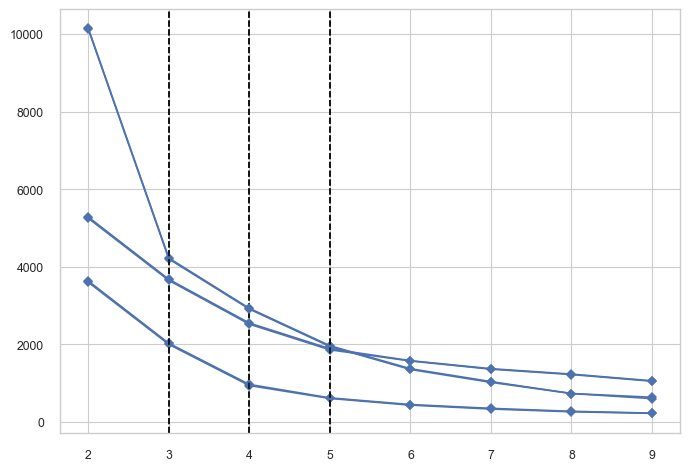

In [733]:
# Compare clustering performance
results_df = evaluate_feature_sets(df, dict_features, scaler=MinMaxScaler())
results_df

In [753]:
dict_features = {
    'rfm_size': ['recent_flag', 'f_returning', 'm_price_log', 'f_basket_size'],

    'rfm_deliv': ['recent_flag', 'f_returning', 'm_price_log', 's_delivery_diff_binary'],

    'rfm_size_deliv': ['recent_flag', 'f_returning', 'm_price_log', 'f_basket_size', 's_delivery_diff_binary'],

    'rfm_bulk_deliv': ['recent_flag', 'f_returning', 'm_price_log', 'f_bulk_flag', 's_delivery_diff_binary'],
}

,feature_set,scaler,best_k_elbow,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,rfm_size,MinMaxScaler,4,0.77,218254.59,0.36
1,rfm_deliv,MinMaxScaler,4,0.75,120052.25,0.49
2,rfm_size_deliv,MinMaxScaler,4,0.74,117791.50,0.51
3,rfm_bulk_deliv,MinMaxScaler,4,0.70,80910.06,0.54


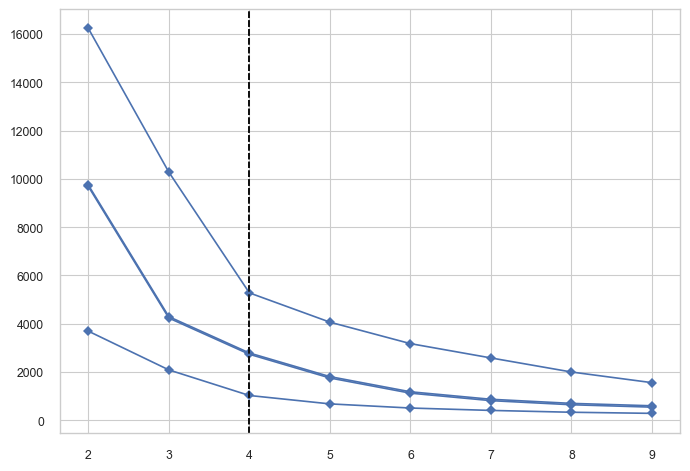

In [755]:
# Compare clustering performance
results_df = evaluate_feature_sets(df, dict_features, scaler=MinMaxScaler())
results_df

In [800]:
dict_features = {
    'rfm_1': ['recent_flag', 'f_returning', 'm_price_log', 's_review_score_cat'],

    'rfm_2': ['recent_flag', 'f_returning', 'm_price_log', 's_delivery_diff_binary', 's_review_score_cat'],

    'rfm_3': ['recent_flag', 'f_returning', 'm_price_log', 'm_purchasing_power'],

    'rfm_4': ['recent_flag', 'f_returning', 'm_price_log', 's_delivery_diff_binary', 'm_purchasing_power'],

}

,feature_set,scaler,best_k_elbow,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,rfm_1,MinMaxScaler,3,0.71,133744.00,0.53
1,rfm_2,MinMaxScaler,4,0.68,82040.88,0.66
2,rfm_3,MinMaxScaler,4,0.72,163637.53,0.56
3,rfm_4,MinMaxScaler,5,0.68,87797.72,0.64


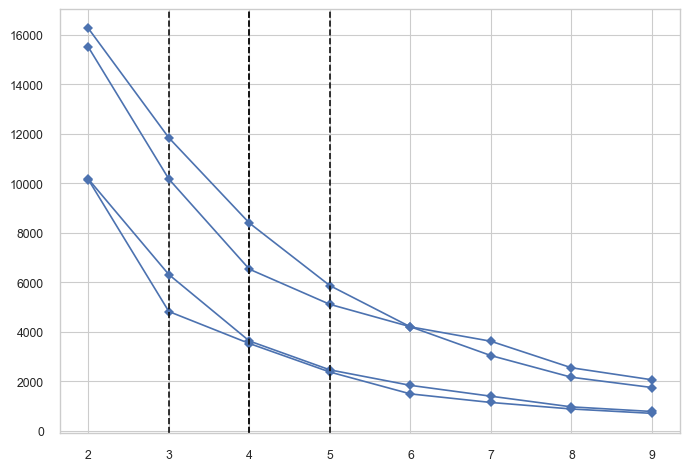

In [802]:
# Compare clustering performance
results_df = evaluate_feature_sets(df, dict_features, scaler=MinMaxScaler())
results_df

Even though rfm_flag_instal performs slightly better, it might be difficult for the marketing team to interpret installment value compared with an absolute figure of price. 

#### Visualise K-Means

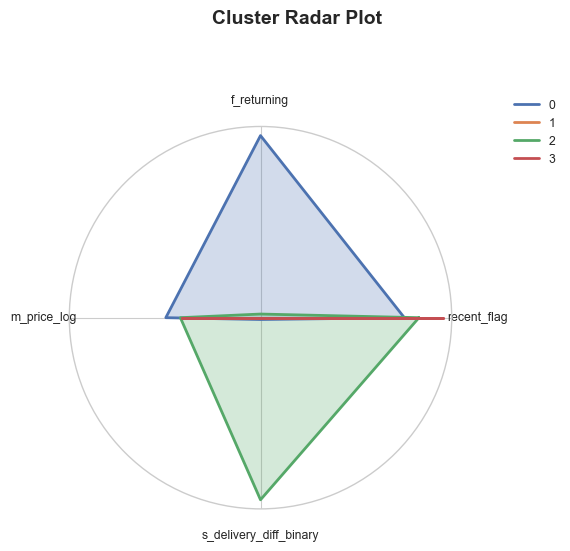

,recent_flag,f_returning,m_price_log,s_delivery_diff_binary
cluster,,,,
0,0.79,1.00,0.52,0.01
1,0.32,0.00,0.43,0.00
2,0.87,0.02,0.44,1.00
3,1.00,0.00,0.43,0.00


In [810]:
# Radar plot
features = ['recent_flag', 'f_returning', 'm_price_log', 's_delivery_diff_binary']

X = df[features].values
X_scaled = MinMaxScaler().fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42).fit(X_scaled)
labels = kmeans.labels_

dfb = pd.DataFrame(X_scaled, columns=features)
dfb['cluster'] = labels

profile = dfb.groupby('cluster').mean().round(2)

plot_cluster_radar(profile)
profile

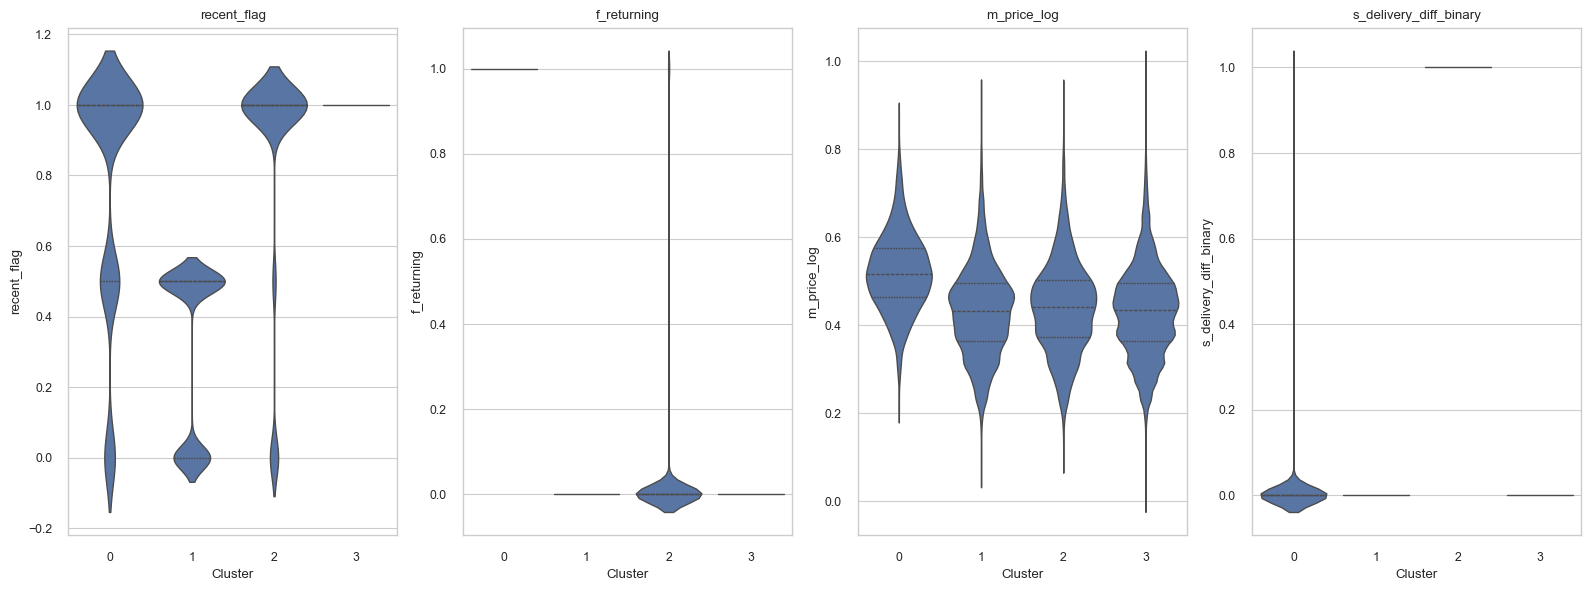

In [814]:
# Violin plot
fig, axes = plt.subplots(1, len(features), figsize=(len(features)*4, 6), sharey=False)

for ax, feature in zip(axes, features):
    sns.violinplot(
        x='cluster', y=feature,
        data=dfb, ax=ax,
        inner='quartile', scale='width'
    )
    ax.set_title(feature)
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)

fig.tight_layout()
plt.show()

#### RFMS and other features

m_value_installments doesn't seem to clearly differentiate clusters so it's been replaced by m_price_log.

Below additional features are added to create more nuanced categories.

In [655]:
dict_features = {
    'rfm_1': ['recent_flag', 'f_returning', 'm_price_log', 'f_basket_size', 's_delivery_diff_binary', 'm_purchasing_power'],

    'rfm_2': ['recent_flag', 'f_returning', 'm_price_log', 'f_basket_size', 's_delivery_diff_binary', 'm_total_installments'],
    
    'rfm_3': ['recent_flag', 'f_returning', 'm_price_log', 'f_basket_size', 's_delivery_diff_binary', 'm_credit'],
    
    'rfm_4': ['recent_flag', 'f_returning', 'm_price_log', 'f_basket_size', 's_delivery_diff_binary', 'state_spending'],
    
    'rfm_5': ['recent_flag', 'f_returning', 'm_price_log', 'f_basket_size', 's_delivery_diff_binary', 'm_pct_freight'],
}

,feature_set,scaler,best_k_elbow,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,rfm_1,MinMaxScaler,5,0.62,55284.91,0.79
1,rfm_2,MinMaxScaler,4,0.65,88564.34,0.59
2,rfm_3,MinMaxScaler,5,0.66,62073.22,0.71
3,rfm_4,MinMaxScaler,4,0.61,73730.44,0.63
4,rfm_5,MinMaxScaler,5,0.54,55129.17,0.68


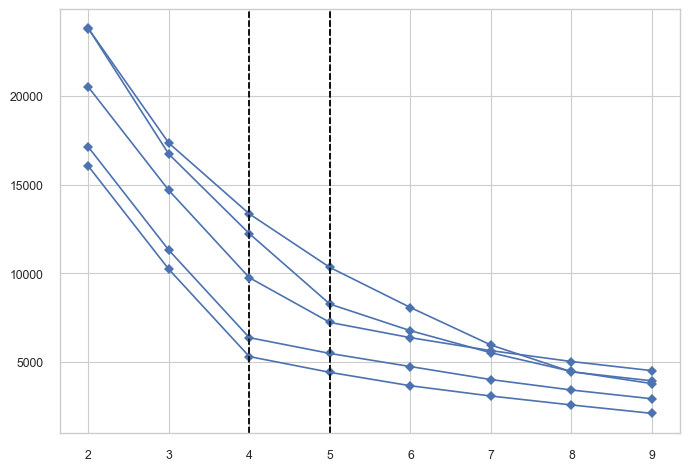

In [657]:
# Compare clustering performance
results_df = evaluate_feature_sets(df, dict_features, scaler=MinMaxScaler())
results_df

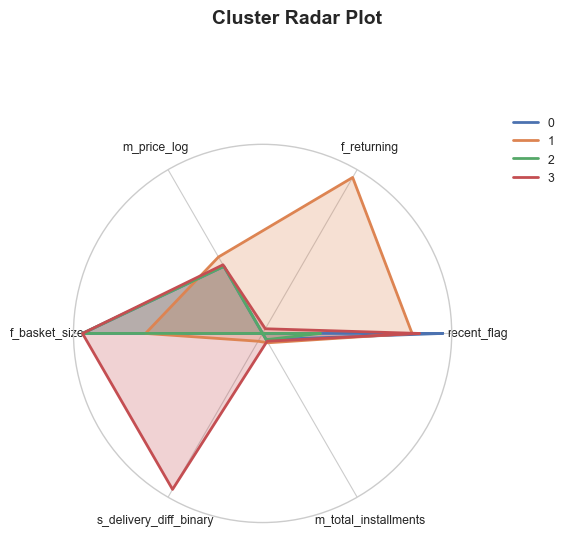

,recent_flag,f_returning,m_price_log,f_basket_size,s_delivery_diff_binary,m_total_installments
cluster,,,,,,
0,1.00,0.00,0.43,1.00,0.00,0.04
1,0.83,1.00,0.49,0.65,0.05,0.06
2,0.32,0.00,0.43,1.00,0.00,0.04
3,0.87,0.03,0.44,1.00,1.00,0.05


In [604]:
# Radar plot
features = ['recent_flag', 'f_returning', 'm_price_log', 'f_basket_size', 's_delivery_diff_binary', 'm_total_installments']

X = df[features].values
X_scaled = MinMaxScaler().fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42).fit(X_scaled)
labels = kmeans.labels_

dfb = pd.DataFrame(X_scaled, columns=features)
dfb['cluster'] = labels

profile = dfb.groupby('cluster').mean().round(2)

plot_cluster_radar(profile)
profile

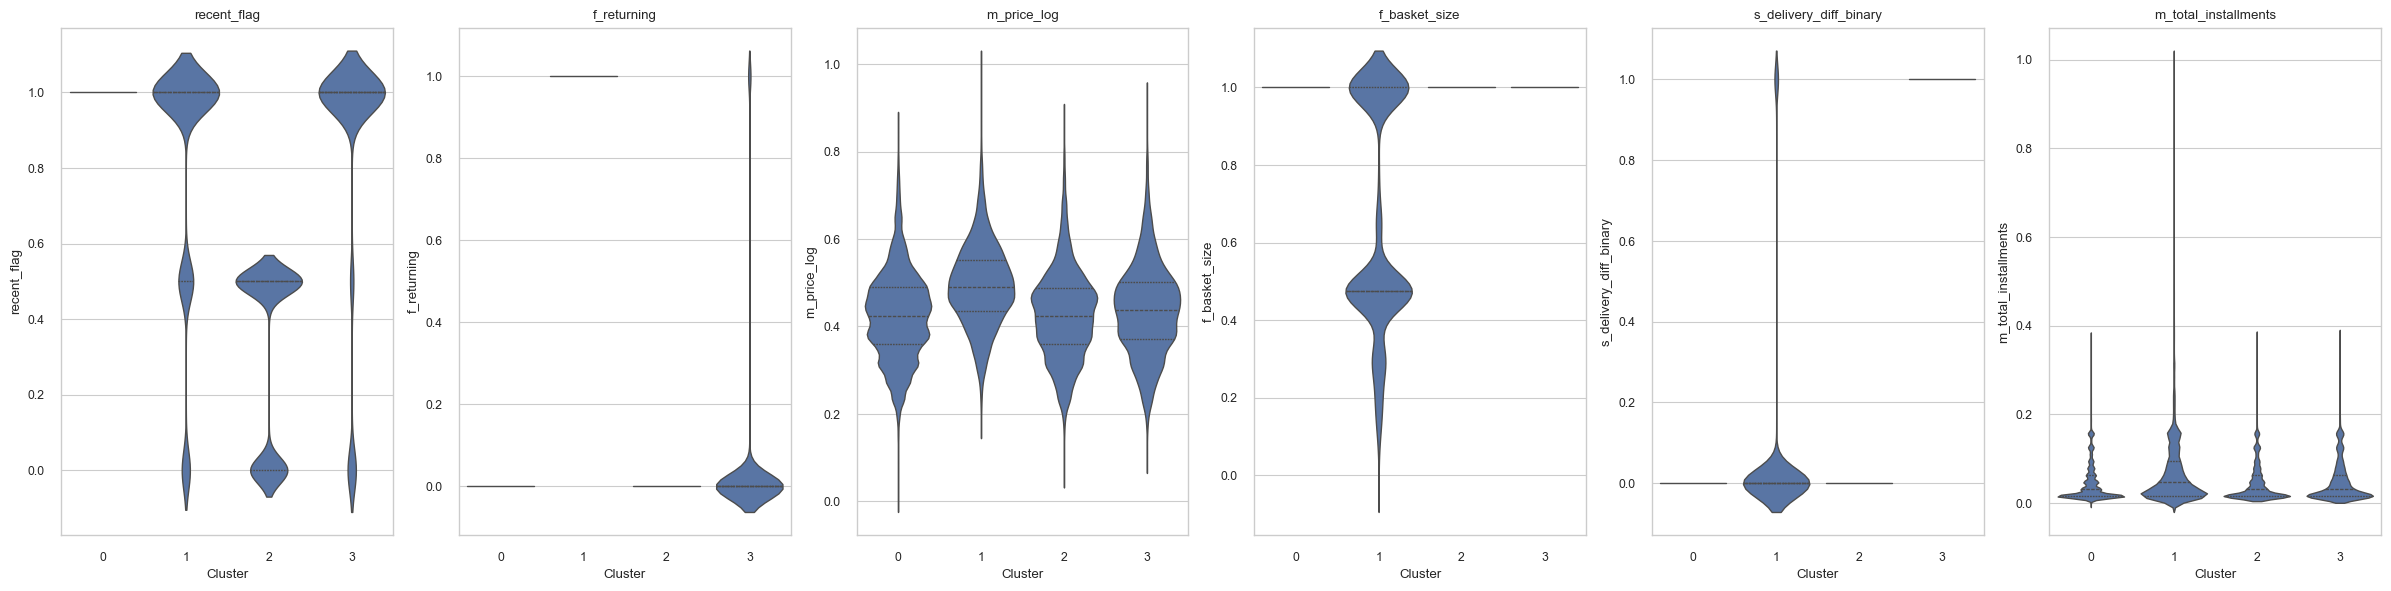

In [606]:
# Violin plot
fig, axes = plt.subplots(1, len(features), figsize=(len(features)*4, 6), sharey=False)

for ax, feature in zip(axes, features):
    sns.violinplot(
        x='cluster', y=feature,
        data=dfb, ax=ax,
        inner='quartile', scale='width'
    )
    ax.set_title(feature)
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)

fig.tight_layout()
plt.show()

The additional features seem to add noise rather than nuance. We will revert back to the simplified RFMS model. 

### 3.2. DBSCAN

In [ ]:
X_cont = RobustScaler().fit_transform(df[['m_price_log','f_basket_size']])
X_mm   = MinMaxScaler().fit_transform(np.hstack([df[['recent_flag','f_returning','s_delivery_diff_binary']].values, X_cont]))


In [664]:
rfm_install_orders = ['recent_flag', 'f_returning', 'm_price_log', 'f_basket_size', 's_delivery_diff_binary']
X = df[rfm_install_orders].values
X_scaled = MinMaxScaler().fit_transform(X)

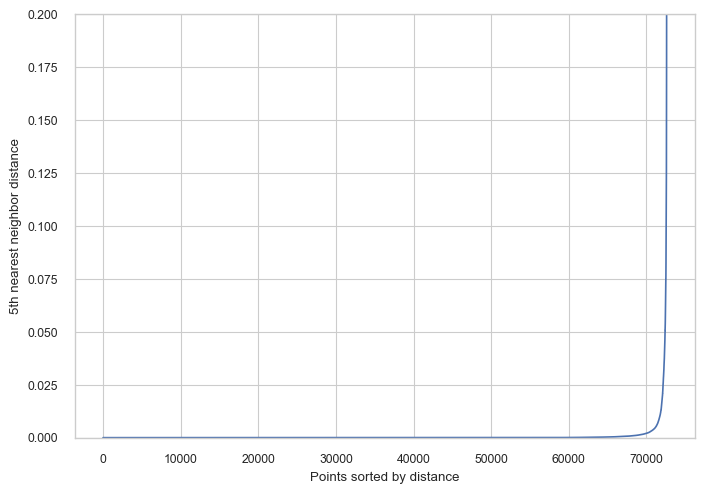

In [477]:
nbrs = NearestNeighbors(n_neighbors=5).fit(X_scaled)
dists, _ = nbrs.kneighbors(X_scaled)
dists = np.sort(dists[:,4])
plt.plot(dists)
plt.ylabel("5th nearest neighbor distance")
plt.xlabel("Points sorted by distance")
plt.ylim(0, 0.2)
plt.axhline(0.5, linestyle='--', color='red')
plt.savefig(f"./results/5th_nearest_neighbor_distance.png")
plt.show()

In [662]:
# DBSCAN clustering
eps_values        = [0.01, 0.05, 0.15, 0.20]
min_samples_vals  = [5, 10, 50]

results = []
for eps in eps_values:
    for ms in min_samples_vals:
        db = DBSCAN(eps=eps, min_samples=ms).fit(X_scaled)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise    = (labels == -1).sum()
        sil = silhouette_score(X_scaled[labels != -1], labels[labels != -1])

        results.append({
            'eps':            eps,
            'min_samples':    ms,
            'n_clusters':     n_clusters,
            'n_noise':        n_noise,
            'silhouette':     sil
        })

df_results = pd.DataFrame(results)
df_results.sort_values(['silhouette','n_clusters'], ascending=[False,True])

KeyboardInterrupt: 

In [479]:
# DBSCAN clustering
db = DBSCAN(eps=0.2, min_samples=50).fit(X_scaled)
labels_db = db.labels_
n_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
print(f"DBSCAN found {n_db} clusters (and {(labels_db==-1).sum()} noise points)")

DBSCAN found 11 clusters (and 91 noise points)


In [281]:
# Silhouette score for DBSCAN
print("Silhouette:", silhouette_score(X_scaled[labels_db!=-1], labels_db[labels_db!=-1]))

Silhouette: 0.7034898736061658


In [481]:
# Observations per cluster
unique, counts = np.unique(labels_db, return_counts=True)
print(dict(zip(unique, counts)))

{-1: 91, 0: 42331, 1: 5988, 2: 5161, 3: 9904, 4: 5556, 5: 1397, 6: 721, 7: 190, 8: 657, 9: 359, 10: 258}


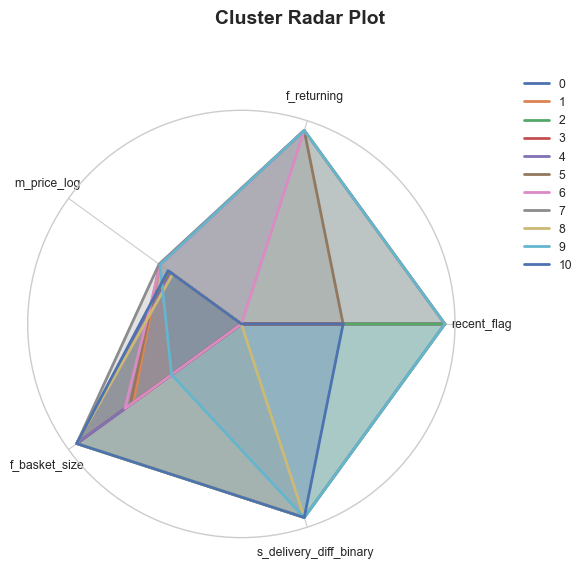

,recent_flag,f_returning,m_price_log,f_basket_size,s_delivery_diff_binary
cluster,,,,,
0,1.00,0.00,0.43,1.00,0.00
1,1.00,1.00,0.49,0.66,0.00
2,1.00,0.00,0.44,1.00,1.00
3,0.50,0.00,0.43,1.00,0.00
4,0.00,0.00,0.43,1.00,0.00
5,0.50,1.00,0.50,0.68,0.00
6,0.00,1.00,0.49,0.71,0.00
7,1.00,1.00,0.50,1.00,1.00
8,0.00,0.00,0.42,1.00,1.00


In [483]:
# Radar plot
df_db = pd.DataFrame(X_scaled, columns=rfm_install_orders)
df_db['cluster'] = labels_db
profile = df_db[df_db['cluster'] != -1].groupby('cluster').mean()
plot_cluster_radar(profile)
profile.round(3)

## 4. Best combination of features

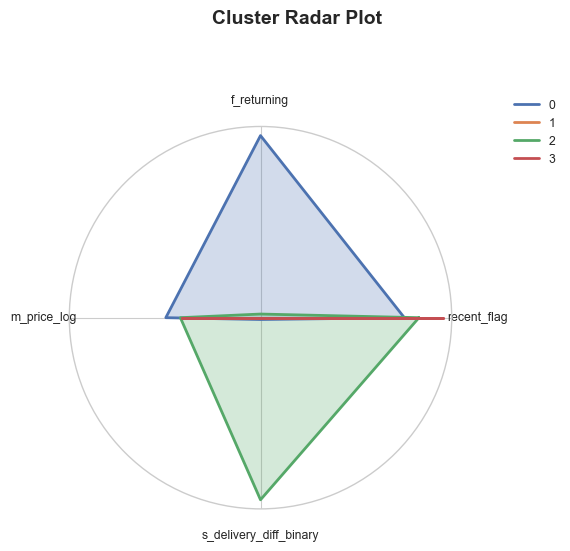

,recent_flag,f_returning,m_price_log,s_delivery_diff_binary
cluster,,,,
0,0.79,1.00,0.52,0.01
1,0.32,0.00,0.43,0.00
2,0.87,0.02,0.44,1.00
3,1.00,0.00,0.43,0.00


In [810]:
# Radar plot
features = ['recent_flag', 'f_returning', 'm_price_log', 's_delivery_diff_binary']

X = df[features].values
X_scaled = MinMaxScaler().fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42).fit(X_scaled)
labels = kmeans.labels_

dfb = pd.DataFrame(X_scaled, columns=features)
dfb['cluster'] = labels

profile = dfb.groupby('cluster').mean().round(2)

plot_cluster_radar(profile)
profile

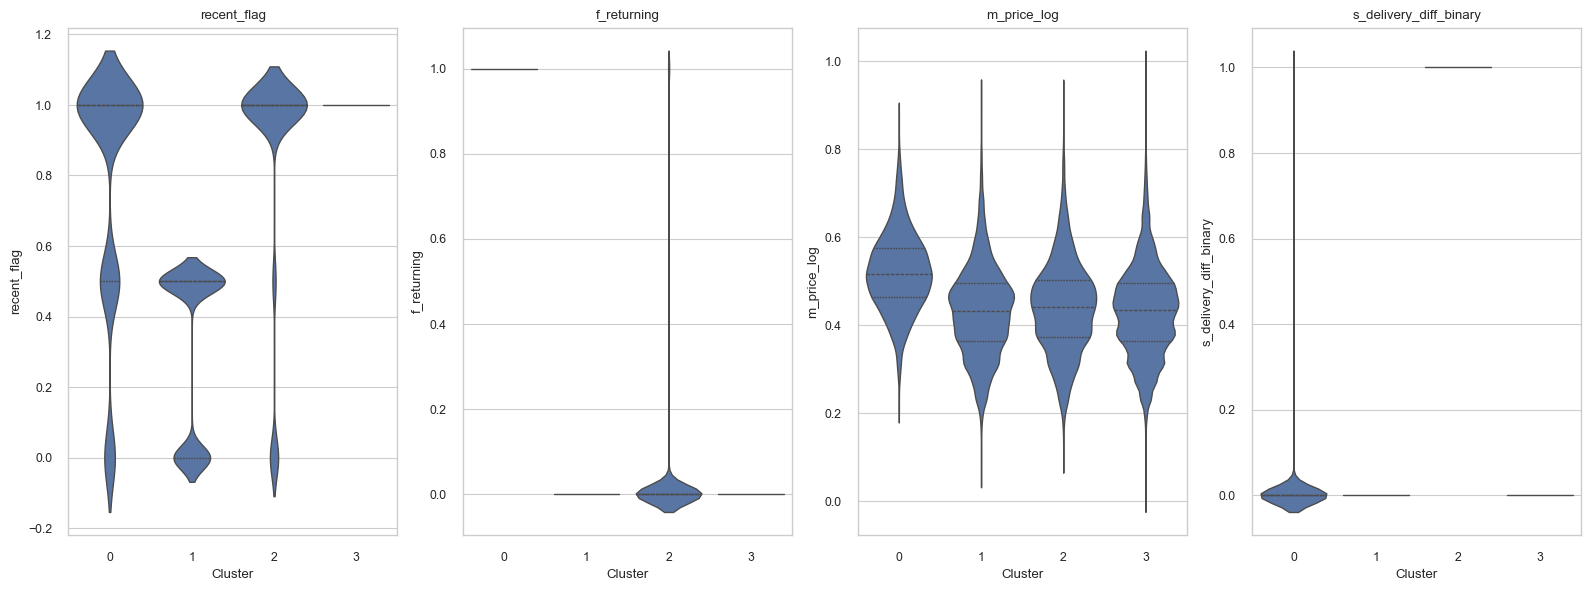

In [814]:
# Violin plot
fig, axes = plt.subplots(1, len(features), figsize=(len(features)*4, 6), sharey=False)

for ax, feature in zip(axes, features):
    sns.violinplot(
        x='cluster', y=feature,
        data=dfb, ax=ax,
        inner='quartile', scale='width'
    )
    ax.set_title(feature)
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)

fig.tight_layout()
plt.show()

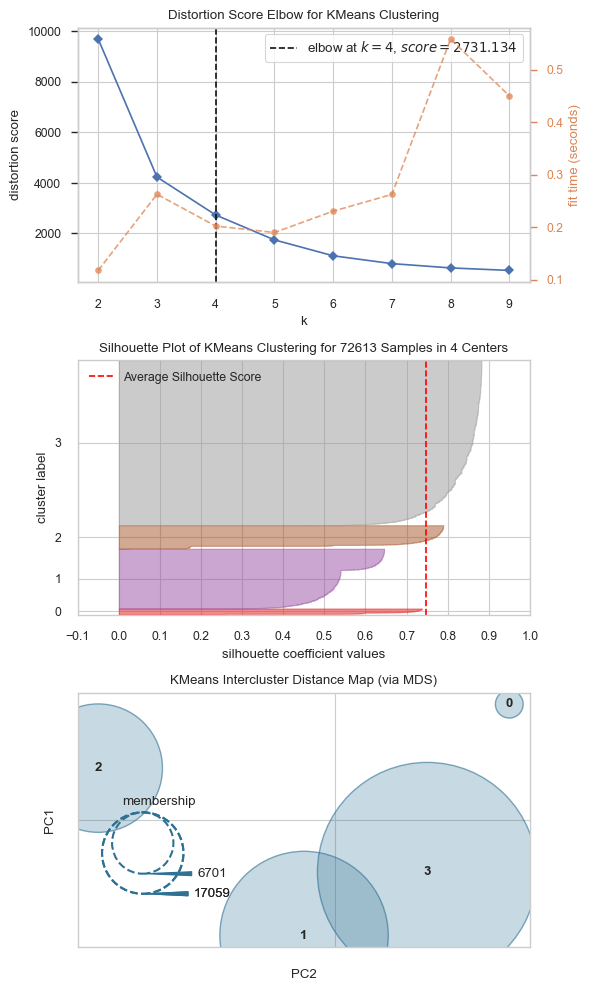

Optimal number of clusters according to the elbow for RFMR: 4


In [816]:
# Evaluate clusters
best_k, fig = evaluate_clusters(
    data=df,
    feature_cols=['recent_flag', 'f_returning', 'm_price_log', 's_delivery_diff_binary'],
    metric="distortion",
    k_min=2,
    k_max=10
)

print("Optimal number of clusters according to the elbow for RFMR:", best_k)